<a href="https://colab.research.google.com/github/rswy/Customer-Churn-Analysis/blob/master/Customer_Churn_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
Customer churn is very important. Understanding the factors that cause customers to churn (stop buying) can make a big difference in a company's revenue.

Thru the following analysis, I hope to come away with some insights on what can be done to prevent a customer from churning

## Objectives


![image.png](attachment:image.png)



### The Insights of my Tableau Dashboard is provided at the bottom of the Notebook

## Defining Churn 

#### Whether a customer has left or is still continuing to make purchases since the last baseline period 

## Defining Churn Rate 


![image.png](attachment:image.png)








#### There are two main components to the churn rate. CHURN and     TOTAL NUMBER OF CUSTOMERS. 


#### If we analyze the factors affecting CHURN well enough, we can have a good understanding of what affects churn rate. 

## Hypothesis: Possible factors affecting churn

- Revenue related
    - Poor customers (who cannot afford high expenditures)
- Product related
    - Customers who are less focused (i.e. buy different products across many categories)
    - Bad products (that turn customers off)
- Customer related
    - Unloyal customers (who switch to other competitors)
    - Infrequent / Once-off customers (buy 1 item and leave for a while or permanently)
    
    - Customers who are at the enterprise level may churn less (bigger more consistent spenders)
    - Customers whose account is suspended (is_suspended feature)

In [0]:
import numpy as np
import pandas as pd
import os 
import sys
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


## Helper Function Created

In [0]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

## Reading In Fact Sales Revenue Table

In [0]:
fact_sales_revenue = pd.read_csv(r'fact_sales_revenue.csv',
                           names = ['territory_sid',
'payer_account_id',
'month_id',
'product_sid',
'sales_revenue'
])
print(fact_sales_revenue.shape)
fact_sales_revenue.head()

(19506609, 5)


,territory_sid,payer_account_id,month_id,product_sid,sales_revenue
0,TS000000000000042942,PA000000000031266032,201704,PHS000000000000035896,0.000000
1,TS000000000000042942,PA000000000031266032,201811,PHS000000000000016228,0.000000
2,TS000000000000042942,PA000000000031266032,201806,PHS000000000000216920,4453.831503
3,TS000000000000042942,PA000000000031266032,201903,PHS000000000000143671,1.574780
4,TS000000000000055985,PA000000000031266032,201605,PHS000000000000035896,0.000000


## Describing the Data 

In [0]:
fact_sales_revenue.describe().T

,count,mean,std,min,25%,50%,75%,max
month_id,19506609.0,201751.967715,130.457765,2.015010e+05,201612.0,201802.0,201901.0,2.019100e+05
sales_revenue,19506609.0,65.519431,4866.951992,-2.350644e+06,0.0,0.0,1.0,1.349303e+07


In [0]:
fact_sales_revenue.describe(include=['object']).T

,count,unique,top,freq
territory_sid,19506609,159,TS000000000000064172,5620625
payer_account_id,19506609,200415,PA000000000019449095,26635
product_sid,19506609,2284,PHS000000000000035896,1425468


In [0]:
fact_sales_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19506609 entries, 0 to 19506608
Data columns (total 5 columns):
territory_sid       object
payer_account_id    object
month_id            int64
product_sid         object
sales_revenue       float64
dtypes: float64(1), int64(1), object(3)
memory usage: 744.1+ MB


## Data Preparation 
- To compare factors affecting churn, we need to analyze the data at the customer level
- The current dataset is provided at the sales/transaction level.
- We therefore need to transform the data from transactions -> customer level aggregation

The following steps will be done to build the customer churn table, which is grouped by payer_account_id and month_id : 

    - 1) Calculate the Churn column 
    - 2) Add customer account features to the customer churn table 
    - 3) Feature Engineer (Add custom) Revenue-related attributes to answer the hypotheses

### 1) Creating the Churn Column! 
- This is a necessary step before any further analysis against churn can be conducted!
- Churn is a column aggregated by payer_account_id and month 
- It tells us whether a customer who exists in the baseline period is still making purchases in the reporting month 

In [0]:
###################################################################################
#### STEP 1: Creating Month and Year Columns For Joining and Grouping By Later #### 
###################################################################################

fact_sales_revenue['month'] = fact_sales_revenue.month_id%100
fact_sales_revenue['year'] = (fact_sales_revenue.month_id/100).astype(int)

###############################################################################################
#### STEP 2: Calculate Baseline Sales by Payer Account ID and year in each Baseline Month (12)####
###############################################################################################

# Obtains fact sales revenue grouped by Payer Account ID and Year for all months = 12 
bl = pd.DataFrame(fact_sales_revenue.loc[(fact_sales_revenue.month==12)]
             .groupby(['payer_account_id','year'])['sales_revenue'].sum()).reset_index()
bl.rename(columns={'sales_revenue':'baseline_sales','year':'baseline_year'},inplace=True)
# Adds a 'year' column to merge with the original FSR data on the reporting year
bl['year'] = bl['baseline_year']+1

#########################################################################################
#### STEP 3: Calculate Total Sales Across each Reporting Month by Payer Account ID ######
#########################################################################################

fsr = pd.merge(fact_sales_revenue,pd.DataFrame(fact_sales_revenue.groupby(['payer_account_id','month_id'])['sales_revenue'].sum()).rename(
    columns={'sales_revenue':'expenses_per_month'}),on=['payer_account_id','month_id'])

############################################################################
#### STEP 4: Calculate Churn for each specific payer_account_id and month_id
############################################################################

# Merge baseline_sales with FSR 
fsr = pd.merge(fsr,bl,on=['payer_account_id','year'])
# https://cmdlinetips.com/2019/05/how-to-create-a-column-using-condition-on-another-column-in-pandas/
fsr['churned']= np.where((fsr.baseline_sales>=1) & (fsr.total_monthly_sales<1),True,False)

fsr.drop(columns='baseline_year',inplace=True)

## ** NOTE : Churn rate will be calculated below after churn analysis is completed 

In [0]:
# # Create Churn Rate Column and merge with Customer Churn Table
# churn_df = customer_churn.groupby(['payer_account_id','month_id','churned'])['expenses_per_month'].nunique().unstack().fillna(0).reset_index()
# customer_churn=pd.merge(customer_churn,churn_df,on=['payer_account_id','month_id'])
   
    
# churn_df_by_payer = churn_df.groupby(['payer_account_id'])[[False,True]].sum().reset_index()
# churn_df_by_payer['churn_rate'] = churn_df_by_payer[True]/(churn_df_by_payer[True]+churn_df_by_payer[False]) 
# customer_churn=pd.merge(customer_churn,churn_df_by_payer[['payer_account_id','churn_rate']],on=['payer_account_id']) 
 

### 2) Add customer account features to the customer churn table 

- Here, I will create the customer churn table for the first time.
    - 1. customer churn table = 'total_monthly_sales','baseline_sales','churned' by customer by month
    - 2. Extract customer account related features from account table and merge them with the customer churn table 
    

In [0]:
fsr.head()

,territory_sid,payer_account_id,month_id,product_sid,sales_revenue,month,year,total_monthly_sales,baseline_sales,churned
0,TS000000000000042942,PA000000000031266032,201704,PHS000000000000035896,0.0,4,2017,8874.440035,31517.992429,False
1,TS000000000000055985,PA000000000031266032,201704,PHS000000000000000001,0.0,4,2017,8874.440035,31517.992429,False
2,TS000000000000042942,PA000000000031266032,201704,PHS000000000000088274,0.0,4,2017,8874.440035,31517.992429,False
3,TS000000000000042942,PA000000000031266032,201704,PHS000000000000093759,0.0,4,2017,8874.440035,31517.992429,False
4,TS000000000000055985,PA000000000031266032,201704,PHS000000000000124150,0.0,4,2017,8874.440035,31517.992429,False


In [0]:
fsr.head()

,territory_sid,month_id,product_sid,sales_revenue,month,year,expenses_per_month,baseline_sales,churned,num_of_purchases_total,num_of_months_with_purchase,perc_of_months_with_purchase,expenses_total,avg_expenses_over_lifetime
payer_account_id,,,,,,,,,,,,,,
PA000000000031266032,TS000000000000042942,201704,PHS000000000000035896,0.0,4,2017,8874.440035,31517.992429,False,3814.0,46.0,1.0,6.148737e+06,133668.197978
PA000000000031266032,TS000000000000055985,201704,PHS000000000000000001,0.0,4,2017,8874.440035,31517.992429,False,3814.0,46.0,1.0,6.148737e+06,133668.197978
PA000000000031266032,TS000000000000042942,201704,PHS000000000000088274,0.0,4,2017,8874.440035,31517.992429,False,3814.0,46.0,1.0,6.148737e+06,133668.197978
PA000000000031266032,TS000000000000042942,201704,PHS000000000000093759,0.0,4,2017,8874.440035,31517.992429,False,3814.0,46.0,1.0,6.148737e+06,133668.197978
PA000000000031266032,TS000000000000055985,201704,PHS000000000000124150,0.0,4,2017,8874.440035,31517.992429,False,3814.0,46.0,1.0,6.148737e+06,133668.197978


In [0]:
customer_churn = fsr.groupby(['payer_account_id','month_id'])['expenses_per_month','baseline_sales','churned'].mean().reset_index()


In [0]:
account  = pd.read_csv('account2.csv',header=None)
account.columns = ["payer_account_id",
"payer_account_company_name",
"payer_account_registration_date",
"payer_account_status_code",
"payer_account_role_name",
"payer_account_creation_date",
"payer_account_last_update_date",
"payer_account_registration_tax_country_code",
"is_payer_account_bill_in_90_days",
"is_payer_account_enterprise",
"is_payer_account_domain_free_domain",
"is_payer_account_on_enterprise_support",
"is_payer_account_on_business_support",
"is_payer_account_fraud",
"is_payer_account_suspended",
"is_payer_account_internal",
"is_payer_account_inp_terminated",
"is_payer_account_on_behalf_of",
"is_payer_account_tax_exempt",
"is_payer_account_reseller",
"payer_account_first_billing_reporting_date",
"payer_account_first_payment_reporting_date",
"payer_account_first_usage_date"
]
act_merge = account[
    ["payer_account_id",
"payer_account_status_code",
"payer_account_role_name",
"payer_account_creation_date",
"payer_account_last_update_date",
"is_payer_account_bill_in_90_days",
"is_payer_account_enterprise",
"is_payer_account_domain_free_domain",
"is_payer_account_on_enterprise_support",
"is_payer_account_fraud",
"is_payer_account_suspended",
"is_payer_account_tax_exempt",
"is_payer_account_reseller",
"payer_account_first_billing_reporting_date",
"payer_account_first_payment_reporting_date",
"payer_account_first_usage_date"
]
    
]

In [0]:
customer_churn = pd.merge(customer_churn,act_merge,how='left',on=['payer_account_id'])

In [0]:
customer_churn.head()

,payer_account_id,month_id,expenses_per_month,baseline_sales,churned,payer_account_status_code,payer_account_role_name,payer_account_creation_date,payer_account_last_update_date,is_payer_account_bill_in_90_days,is_payer_account_enterprise,is_payer_account_domain_free_domain,is_payer_account_on_enterprise_support,is_payer_account_fraud,is_payer_account_suspended,is_payer_account_tax_exempt,is_payer_account_reseller,payer_account_first_billing_reporting_date,payer_account_first_payment_reporting_date,payer_account_first_usage_date
0,PA000000000000001438,201601,25.44,3.37,False,Suspended,Regular,2014-12-18 17:00:58,2016-03-25 23:32:09,N,N,Y,N,N,Y,N,N,2014-12-01 00:00:00,2014-12-01 00:00:00,2014-12-18 00:00:00
1,PA000000000000001438,201602,23.97,3.37,False,Suspended,Regular,2014-12-18 17:00:58,2016-03-25 23:32:09,N,N,Y,N,N,Y,N,N,2014-12-01 00:00:00,2014-12-01 00:00:00,2014-12-18 00:00:00
2,PA000000000000001624,201601,3.32,4.49,False,Suspended,Regular,2015-11-04 05:40:29,2016-03-25 23:31:31,N,N,N,N,N,Y,N,N,2015-11-01 00:00:00,2015-12-01 00:00:00,2015-11-11 00:00:00
3,PA000000000000001624,201602,0.52,4.49,True,Suspended,Regular,2015-11-04 05:40:29,2016-03-25 23:31:31,N,N,N,N,N,Y,N,N,2015-11-01 00:00:00,2015-12-01 00:00:00,2015-11-11 00:00:00
4,PA000000000000001869,201801,47.09,47.09,False,Suspended,Regular,2010-05-22 04:25:29,2019-11-25 15:09:44,Y,N,Y,N,N,Y,N,N,2017-04-01 00:00:00,2017-04-01 00:00:00,2017-04-26 00:00:00


### 3) Feature Engineer (Add custom) Revenue-related attributes to answer the hypotheses

###   ***** *ASSUMPTION: A purchase is made if the sales_revenue for the transaction > 1.00 dollar*

In [0]:
#### Set the index to payer_account_id 
fsr = fsr.set_index('payer_account_id')

#### Create 3 new *Purchase Frequency* features in the customer churn table to address following hypotheses:

- Whether a customer is a one-off purchase customer (total number of purchases =1 or months with purchase =1)
- Whether a customer is loyal or not ( percentage of months with purchases >80% )

#### *Purchase Frequency* Features Created:
- 1) total number of purchases made by each customer
- 2) total number of months with purchases made by each customer 
- 3) percentage of months with purchases made by each customer 



In [0]:
num_actual_purchases_per_month = fsr.loc[fsr.sales_revenue>0].groupby(['payer_account_id','month_id']).count().num_of_purchases_total.reset_index()
num_actual_purchases_per_month ['count_distinct'] = 1

fsr['num_of_purchases_total'] = fsr.loc[fsr.sales_revenue>0].groupby(['payer_account_id']).count().territory_sid.fillna(0)

fsr['num_of_months_with_purchase']= num_actual_purchases_per_month.groupby('payer_account_id').count_distinct.sum()

customer_lifetime_in_months = fsr.groupby(['payer_account_id']).month_id.nunique()
fsr['perc_of_months_with_purchase']= num_actual_purchases_per_month.groupby('payer_account_id').count_distinct.sum()/ customer_lifetime_in_months



KeyError: 'payer_account_id'

In [0]:
num_purchases = fsr[['num_of_purchases_total','num_of_months_with_purchase','perc_of_months_with_purchase']].groupby(fsr.index).mean()
customer_churn = pd.merge(customer_churn,num_purchases,how='left',on=['payer_account_id'])

In [0]:
customer_churn.head()

,payer_account_id,month_id,expenses_per_month,baseline_sales,churned,payer_account_status_code,payer_account_role_name,payer_account_creation_date,payer_account_last_update_date,is_payer_account_bill_in_90_days,...,is_payer_account_fraud,is_payer_account_suspended,is_payer_account_tax_exempt,is_payer_account_reseller,payer_account_first_billing_reporting_date,payer_account_first_payment_reporting_date,payer_account_first_usage_date,num_of_purchases_total,num_of_months_with_purchase,perc_of_months_with_purchase
0,PA000000000000001438,201601,25.44,3.37,False,Suspended,Regular,2014-12-18 17:00:58,2016-03-25 23:32:09,N,...,N,Y,N,N,2014-12-01 00:00:00,2014-12-01 00:00:00,2014-12-18 00:00:00,10.0,2.0,1.0
1,PA000000000000001438,201602,23.97,3.37,False,Suspended,Regular,2014-12-18 17:00:58,2016-03-25 23:32:09,N,...,N,Y,N,N,2014-12-01 00:00:00,2014-12-01 00:00:00,2014-12-18 00:00:00,10.0,2.0,1.0
2,PA000000000000001624,201601,3.32,4.49,False,Suspended,Regular,2015-11-04 05:40:29,2016-03-25 23:31:31,N,...,N,Y,N,N,2015-11-01 00:00:00,2015-12-01 00:00:00,2015-11-11 00:00:00,2.0,2.0,1.0
3,PA000000000000001624,201602,0.52,4.49,True,Suspended,Regular,2015-11-04 05:40:29,2016-03-25 23:31:31,N,...,N,Y,N,N,2015-11-01 00:00:00,2015-12-01 00:00:00,2015-11-11 00:00:00,2.0,2.0,1.0
4,PA000000000000001869,201801,47.09,47.09,False,Suspended,Regular,2010-05-22 04:25:29,2019-11-25 15:09:44,Y,...,N,Y,N,N,2017-04-01 00:00:00,2017-04-01 00:00:00,2017-04-26 00:00:00,65.0,17.0,1.0


#### Create 2 new purchase revenue features in the customer churn table to address following hypotheses:

- Whether a customer is a small purchase customer or not 
    - Average lifetime expenditure falls within the lower 25th percentile of the distribution of customer expenditure 
  
  

##### Features Created:
- 1) total expenditure by each customer
- 2) average expenditure of each customer across lifetime with company 



In [0]:
fsr['expenses_total'] = fsr.groupby(['payer_account_id']).sum().sales_revenue
customer_lifetime_in_months = fsr.groupby(['payer_account_id']).month_id.nunique()
fsr['avg_expenses_over_lifetime']= fsr.groupby(['payer_account_id']).sum().sales_revenue / customer_lifetime_in_months


In [0]:
fsr

,territory_sid,month_id,product_sid,sales_revenue,month,year,expenses_per_month,baseline_sales,churned,num_of_purchases_total,num_of_months_with_purchase,perc_of_months_with_purchase,expenses_total,avg_expenses_over_lifetime
payer_account_id,,,,,,,,,,,,,,
PA000000000031266032,TS000000000000042942,201704,PHS000000000000035896,0.000000,4,2017,8874.440035,31517.992429,False,3814.0,46.0,1.0,6.148737e+06,133668.197978
PA000000000031266032,TS000000000000055985,201704,PHS000000000000000001,0.000000,4,2017,8874.440035,31517.992429,False,3814.0,46.0,1.0,6.148737e+06,133668.197978
PA000000000031266032,TS000000000000042942,201704,PHS000000000000088274,0.000000,4,2017,8874.440035,31517.992429,False,3814.0,46.0,1.0,6.148737e+06,133668.197978
PA000000000031266032,TS000000000000042942,201704,PHS000000000000093759,0.000000,4,2017,8874.440035,31517.992429,False,3814.0,46.0,1.0,6.148737e+06,133668.197978
PA000000000031266032,TS000000000000055985,201704,PHS000000000000124150,0.000000,4,2017,8874.440035,31517.992429,False,3814.0,46.0,1.0,6.148737e+06,133668.197978
PA000000000031266032,TS000000000000055985,201704,PHS000000000000178708,0.000000,4,2017,8874.440035,31517.992429,False,3814.0,46.0,1.0,6.148737e+06,133668.197978
PA000000000031266032,TS000000000000042942,201704,PHS000000000000123778,0.000000,4,2017,8874.440035,31517.992429,False,3814.0,46.0,1.0,6.148737e+06,133668.197978
PA000000000031266032,TS000000000000057536,201704,PHS000000000000000060,70.269454,4,2017,8874.440035,31517.992429,False,3814.0,46.0,1.0,6.148737e+06,133668.197978
PA000000000031266032,TS000000000000042942,201704,PHS000000000000048225,0.000000,4,2017,8874.440035,31517.992429,False,3814.0,46.0,1.0,6.148737e+06,133668.197978


In [0]:
cust_expenses = fsr[['expenses_total','avg_expenses_over_lifetime']].groupby(fsr.index).mean()
customer_churn = pd.merge(customer_churn,cust_expenses,how='left',on=['payer_account_id'])

In [0]:
customer_churn.columns

Index(['payer_account_id', 'month_id', 'expenses_per_month', 'baseline_sales',
       'churned', 'payer_account_status_code', 'payer_account_role_name',
       'payer_account_creation_date', 'payer_account_last_update_date',
       'is_payer_account_bill_in_90_days', 'is_payer_account_enterprise',
       'is_payer_account_domain_free_domain',
       'is_payer_account_on_enterprise_support', 'is_payer_account_fraud',
       'is_payer_account_suspended', 'is_payer_account_tax_exempt',
       'is_payer_account_reseller',
       'payer_account_first_billing_reporting_date',
       'payer_account_first_payment_reporting_date',
       'payer_account_first_usage_date', 'num_of_purchases_total',
       'num_of_months_with_purchase', 'perc_of_months_with_purchase',
       'expenses_total', 'avg_expenses_over_lifetime'],
      dtype='object')

In [0]:
customer_churn.head()

,payer_account_id,month_id,expenses_per_month,baseline_sales,churned,payer_account_status_code,payer_account_role_name,payer_account_creation_date,payer_account_last_update_date,is_payer_account_bill_in_90_days,...,is_payer_account_tax_exempt,is_payer_account_reseller,payer_account_first_billing_reporting_date,payer_account_first_payment_reporting_date,payer_account_first_usage_date,num_of_purchases_total,num_of_months_with_purchase,perc_of_months_with_purchase,expenses_total,avg_expenses_over_lifetime
0,PA000000000000001438,201601,25.44,3.37,False,Suspended,Regular,2014-12-18 17:00:58,2016-03-25 23:32:09,N,...,N,N,2014-12-01 00:00:00,2014-12-01 00:00:00,2014-12-18 00:00:00,10.0,2.0,1.0,49.410000,24.705000
1,PA000000000000001438,201602,23.97,3.37,False,Suspended,Regular,2014-12-18 17:00:58,2016-03-25 23:32:09,N,...,N,N,2014-12-01 00:00:00,2014-12-01 00:00:00,2014-12-18 00:00:00,10.0,2.0,1.0,49.410000,24.705000
2,PA000000000000001624,201601,3.32,4.49,False,Suspended,Regular,2015-11-04 05:40:29,2016-03-25 23:31:31,N,...,N,N,2015-11-01 00:00:00,2015-12-01 00:00:00,2015-11-11 00:00:00,2.0,2.0,1.0,3.840000,1.920000
3,PA000000000000001624,201602,0.52,4.49,True,Suspended,Regular,2015-11-04 05:40:29,2016-03-25 23:31:31,N,...,N,N,2015-11-01 00:00:00,2015-12-01 00:00:00,2015-11-11 00:00:00,2.0,2.0,1.0,3.840000,1.920000
4,PA000000000000001869,201801,47.09,47.09,False,Suspended,Regular,2010-05-22 04:25:29,2019-11-25 15:09:44,Y,...,N,N,2017-04-01 00:00:00,2017-04-01 00:00:00,2017-04-26 00:00:00,65.0,17.0,1.0,1133.886653,66.699215


### Save final customer churn dataset

In [0]:
customer_churn.to_csv('output/customer_churn.csv')

## Data Exploration

In [0]:
customer_churn['churned'] = customer_churn['churned'].map({True: 1, False: 0})

In [0]:
# customer_churn=pd.read_csv('output/customer_churn.csv')

False    939126
True      27744
Name: churned, dtype: int64


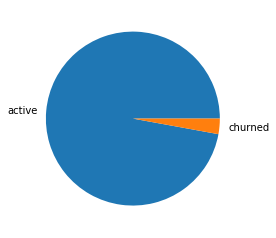

In [0]:
churn_count = customer_churn.churned.value_counts()
print(churn_count)

# Using matplotlib  to plot customer_churn pie chart
plt.pie(churn_count,labels=['active','churned']);

In [0]:
customer_churn.describe().T

,count,mean,std,min,25%,50%,75%,max
month_id,966870.0,201781.881071,1.067727e+02,201601.000000,201704.000000,201804.000000,201902.000000,2.019100e+05
expenses_per_month,966870.0,1113.515989,4.008409e+04,-248182.496660,1.020000,13.690000,100.030000,2.093128e+07
baseline_sales,966870.0,1009.586931,2.866653e+04,-80720.370000,1.000000,12.320000,89.700000,6.783956e+06
num_of_purchases_total,914060.0,198.944631,3.282600e+02,1.000000,38.000000,98.000000,247.000000,1.569200e+04
num_of_months_with_purchase,914060.0,28.554333,1.464921e+01,1.000000,15.000000,31.000000,46.000000,4.600000e+01
perc_of_months_with_purchase,914060.0,0.997928,2.825596e-02,0.021739,1.000000,1.000000,1.000000,1.000000e+00
expenses_total,966870.0,42315.422950,1.261819e+06,-2700.140021,42.119988,373.579999,3453.157556,1.725098e+08
avg_expenses_over_lifetime,966870.0,1113.515989,2.816878e+04,-1219.354800,2.257631,16.142059,123.498662,3.750213e+06


In [0]:
churns = customer_churn.loc[customer_churn.churned==True]
churns= churns.dropna()
not_churns = customer_churn.loc[customer_churn.churned==False]
not_churns= not_churns.dropna()

C:\Users\ranon\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


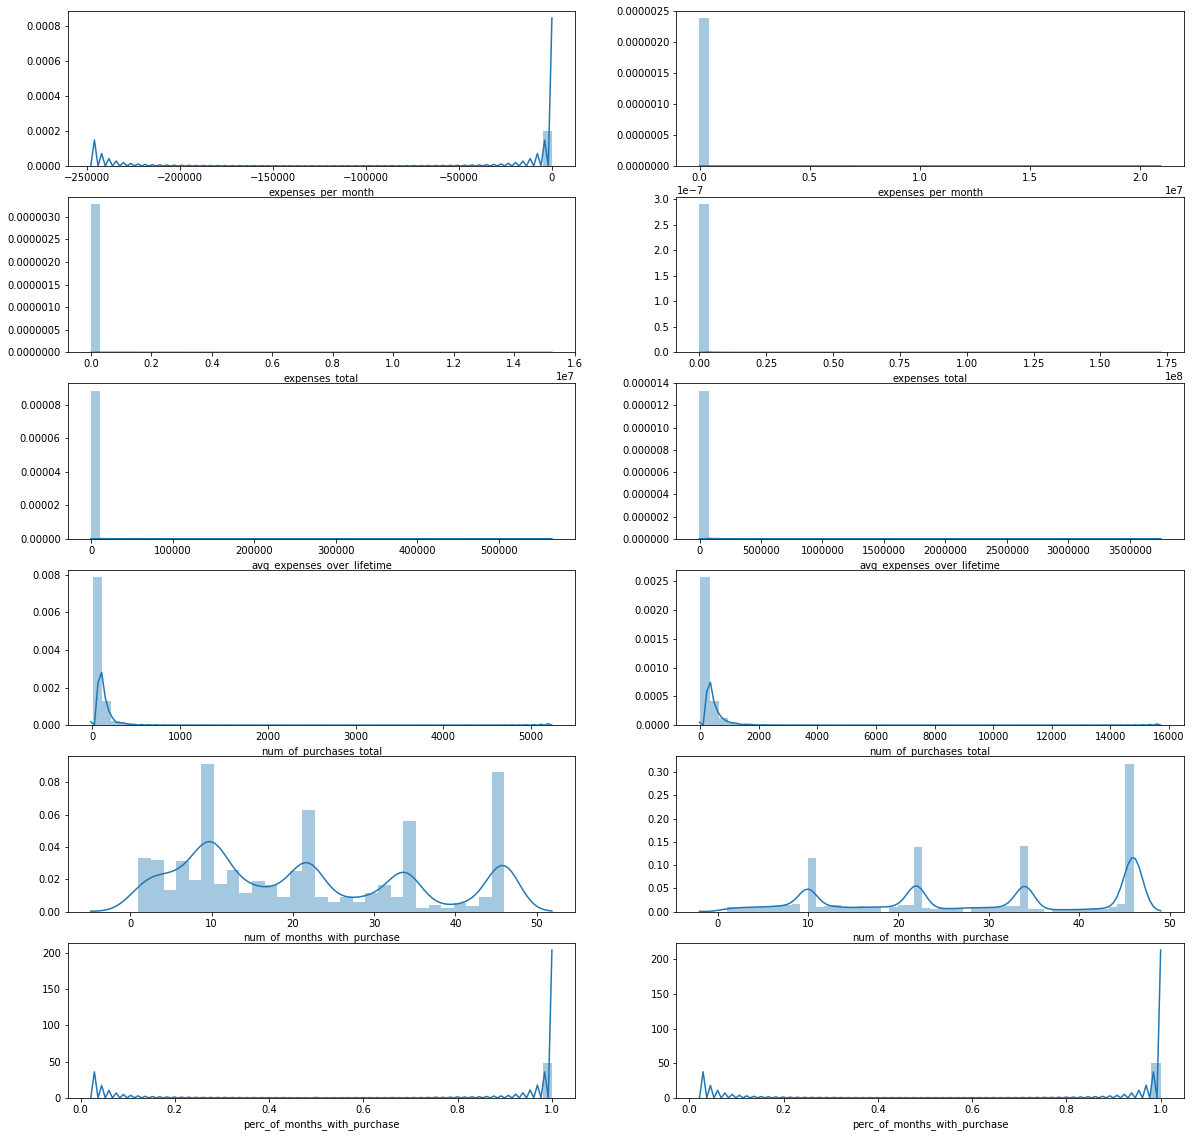

In [0]:
# Create a figure instance, and the two subplots
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(621)
ax2 = fig.add_subplot(622)
ax3 = fig.add_subplot(623)
ax4 = fig.add_subplot(624)
ax5 = fig.add_subplot(625)
ax6 = fig.add_subplot(626)
ax7 = fig.add_subplot(627)
ax8 = fig.add_subplot(628)
ax9 = fig.add_subplot(629)
ax10 = fig.add_subplot(6,2,10)
ax11 = fig.add_subplot(6,2,11)
ax12 = fig.add_subplot(6,2,12)


# Tell pointplot to plot on ax1 with the ax argument (satisfaction level)
sns.distplot(churns['expenses_per_month'],ax = ax1);
sns.distplot(not_churns['expenses_per_month'],ax = ax2);
sns.distplot(churns['expenses_total'],ax = ax3);
sns.distplot(not_churns['expenses_total'],ax = ax4);
sns.distplot(churns['avg_expenses_over_lifetime'], kde=True,ax=ax5);
sns.distplot(not_churns['avg_expenses_over_lifetime'], kde=True,ax=ax6);
sns.distplot(churns['num_of_purchases_total'], kde=True,ax=ax7);
sns.distplot(not_churns['num_of_purchases_total'], kde=True,ax=ax8);
sns.distplot(churns['num_of_months_with_purchase'], kde=True,ax=ax9);
sns.distplot(not_churns['num_of_months_with_purchase'], kde=True,ax=ax10);
sns.distplot(churns['perc_of_months_with_purchase'], kde=True,ax=ax11);
sns.distplot(not_churns['perc_of_months_with_purchase'], kde=True,ax=ax12);

In [0]:
customer_churn_dropna = customer_churn.dropna()

In [0]:
customer_churn_corr = customer_churn[['expenses_per_month','expenses_total','avg_expenses_over_lifetime','num_of_purchases_total',
'num_of_months_with_purchase','perc_of_months_with_purchase']].corr()

customer_churn_corr

,expenses_per_month,expenses_total,avg_expenses_over_lifetime,num_of_purchases_total,num_of_months_with_purchase,perc_of_months_with_purchase
expenses_per_month,1.000000,0.693740,0.702742,0.145661,0.018277,-0.000281
expenses_total,0.693740,1.000000,0.987190,0.200002,0.030980,0.000087
avg_expenses_over_lifetime,0.702742,0.987190,1.000000,0.207279,0.026009,-0.000400
num_of_purchases_total,0.145661,0.200002,0.207279,1.000000,0.400615,0.018584
num_of_months_with_purchase,0.018277,0.030980,0.026009,0.400615,1.000000,0.086057
perc_of_months_with_purchase,-0.000281,0.000087,-0.000400,0.018584,0.086057,1.000000


### From here we can see that the expense features are strongly correlated with each other, which is to be expected

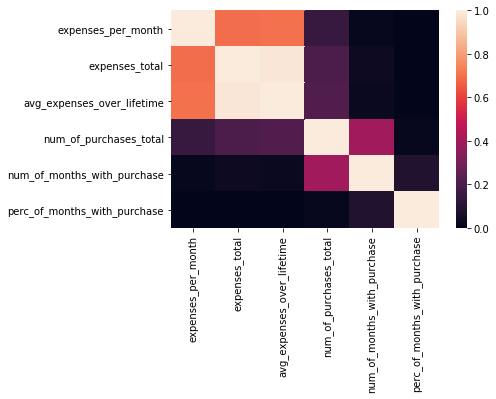

In [0]:
sns.heatmap(customer_churn_corr)

### Let's try to answer each hypothesis at a time. Let's recap them here: 

HYPOTHESES:
- Customer related
    - 1) Unloyal customers (who switch to other competitors)
    - 2) Infrequent / Once-off customers (buy 1 item and leave for a while or permanently)
    
    - 3) Customers who are at the enterprise level may churn less (bigger more consistent spenders)
    - 4) Customers whose account is suspended (is_suspended feature)
- Revenue related
    - 5) Poor customers (who cannot afford high expenditures)
- Product related
    - 6) Customers who are less focused (i.e. buy different products across many categories)
    - 7) Bad products (that turn customers off)


## Hypothesis 1: Unloyal customers (who switch to other competitors) may have a higher risk of churn 

- We define loyal customers as customers whose purchase more than 80% of their lifetime with the company:
    - To get this, we check if "perc_of_months_with_purchase" >80% for each customer
    
![image.png](attachment:image.png)   
    
#### One can tell from the distribution plot above that most customers are 'loyal'

In [0]:
customer_churn.perc_of_months_with_purchase.describe()

count    914060.000000
mean          0.997928
std           0.028256
min           0.021739
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: perc_of_months_with_purchase, dtype: float64

In [0]:
not_loyal = customer_churn.loc[customer_churn.perc_of_months_with_purchase<0.8]
loyal =  customer_churn.loc[customer_churn.perc_of_months_with_purchase>=0.8]

loyal_counts=loyal['churned'].value_counts()
unloyal_counts=not_loyal['churned'].value_counts()
 

[LEFT] Percentage of Loyal customers who churn: 2.962823174183808 %

[RIGHT] Percentage of unloyal customers who churn: 20.972644376899694 %


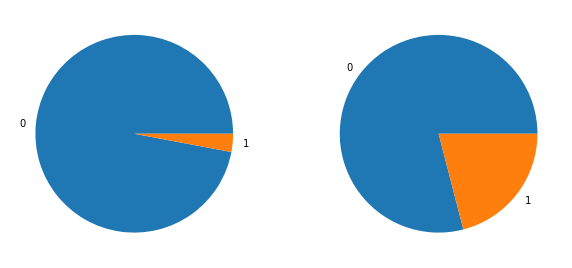

In [0]:
# create a figure with two subplots
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
      
# plot each pie chart in a separate subplot
print(f"[LEFT] Percentage of Loyal customers who churn: {loyal['churned'].value_counts()[1]/len(loyal)*100} %")
ax1.pie(loyal_counts,labels=loyal_counts.index);
print("")
print(f"[RIGHT] Percentage of unloyal customers who churn: {not_loyal['churned'].value_counts()[1]/len(not_loyal)*100} %")
ax2.pie(unloyal_counts,labels=unloyal_counts.index);

### Conclusion:
A larger Proportion of unloyal customers churn compared to loyal customers.

### Action Plan: 
We should consider identifying the group of unloyal customers and devise strategies e.g. loyalty campaigns to convert them into loyal customers

## Hypothesis 2: Smaller ticket/budget customers have a higher risk of churn 


### - We define smaller purchase customers as customers whose AVERAGE LIFETIME EXPENDITURE is low. To get this,
    - we check if "avg_expenses_over_lifetime" falls within the lower 25th percentile of the distribution of customer expenditure.
  


##### Distribution of Average Expenses in customer Lifetime
- 1) avg_expenses_over_lifetime
 


In [0]:
customer_churn_outlier_gone = remove_outlier(customer_churn,'avg_expenses_over_lifetime')
customer_churn_outlier_gone['avg_expenses_over_lifetime'].describe()

count    807657.000000
mean         37.574309
std          62.046936
min        -148.460000
25%           1.443000
50%           9.948000
75%          41.372941
max         305.224615
Name: avg_expenses_over_lifetime, dtype: float64

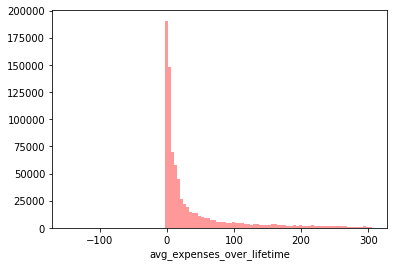

In [0]:
sns.distplot(customer_churn_outlier_gone['avg_expenses_over_lifetime'], kde = False, color ='red', bins = 100)

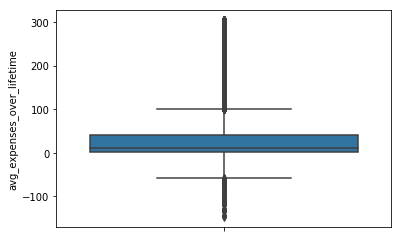

In [0]:
sns.boxplot( y = 'avg_expenses_over_lifetime', data = customer_churn_outlier_gone.reset_index())

In [0]:
customer_churn_outlier_gone.avg_expenses_over_lifetime.describe()

count    807657.000000
mean         37.574309
std          62.046936
min        -148.460000
25%           1.443000
50%           9.948000
75%          41.372941
max         305.224615
Name: avg_expenses_over_lifetime, dtype: float64

In [0]:
expenditure_bin_labels = ['low', 'average', 'high', 'very_high']
customer_churn_outlier_gone['avg_expenses_over_lifetime_category'] = pd.qcut(customer_churn_outlier_gone['avg_expenses_over_lifetime'],
                              q=[0.1, 0.35,0.6,0.85, 1],
                              labels=expenditure_bin_labels)
customer_churn_outlier_gone.head()

C:\Users\ranon\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Unnamed: 0,payer_account_id,month_id,expenses_per_month,baseline_sales,churned,payer_account_status_code,payer_account_role_name,payer_account_creation_date,payer_account_last_update_date,...,is_payer_account_reseller,payer_account_first_billing_reporting_date,payer_account_first_payment_reporting_date,payer_account_first_usage_date,num_of_purchases_total,num_of_months_with_purchase,perc_of_months_with_purchase,expenses_total,avg_expenses_over_lifetime,avg_expenses_over_lifetime_category
0,0,PA000000000000001438,201601,25.44,3.37,False,Suspended,Regular,2014-12-18 17:00:58,2016-03-25 23:32:09,...,N,2014-12-01 00:00:00,2014-12-01 00:00:00,2014-12-18 00:00:00,10.0,2.0,1.0,49.410000,24.705000,high
1,1,PA000000000000001438,201602,23.97,3.37,False,Suspended,Regular,2014-12-18 17:00:58,2016-03-25 23:32:09,...,N,2014-12-01 00:00:00,2014-12-01 00:00:00,2014-12-18 00:00:00,10.0,2.0,1.0,49.410000,24.705000,high
2,2,PA000000000000001624,201601,3.32,4.49,False,Suspended,Regular,2015-11-04 05:40:29,2016-03-25 23:31:31,...,N,2015-11-01 00:00:00,2015-12-01 00:00:00,2015-11-11 00:00:00,2.0,2.0,1.0,3.840000,1.920000,low
3,3,PA000000000000001624,201602,0.52,4.49,True,Suspended,Regular,2015-11-04 05:40:29,2016-03-25 23:31:31,...,N,2015-11-01 00:00:00,2015-12-01 00:00:00,2015-11-11 00:00:00,2.0,2.0,1.0,3.840000,1.920000,low
4,4,PA000000000000001869,201801,47.09,47.09,False,Suspended,Regular,2010-05-22 04:25:29,2019-11-25 15:09:44,...,N,2017-04-01 00:00:00,2017-04-01 00:00:00,2017-04-26 00:00:00,65.0,17.0,1.0,1133.886653,66.699215,high


C:\Users\ranon\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\ranon\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


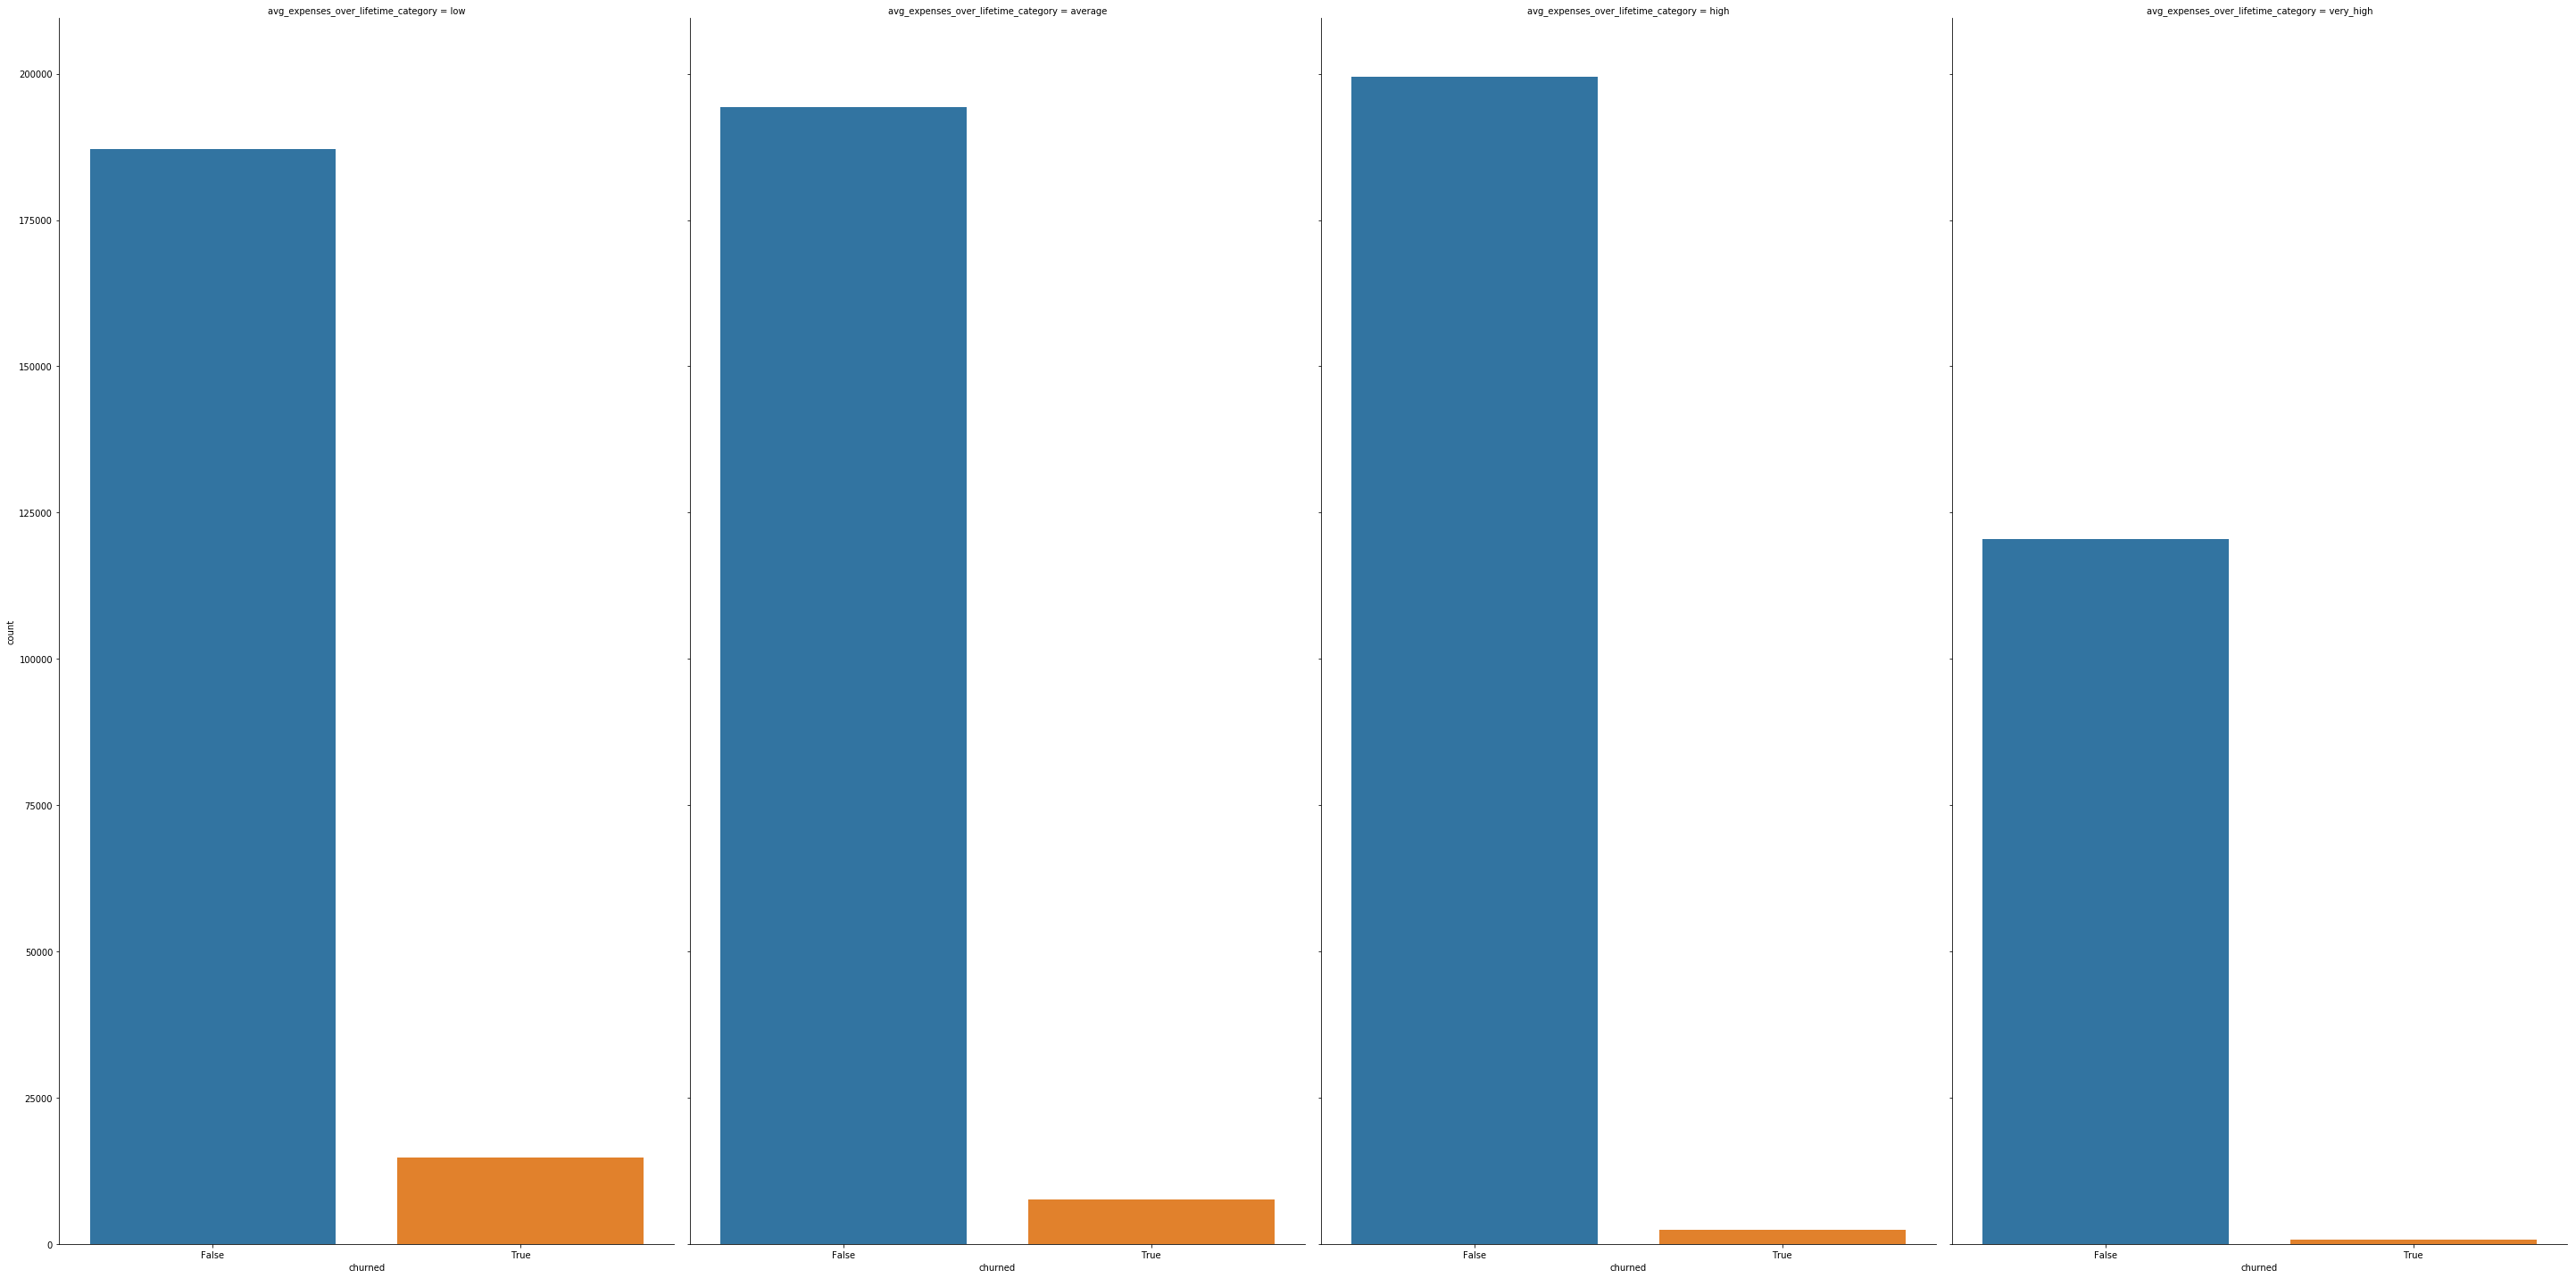

In [0]:
sns.factorplot(x="churned",data=customer_churn_outlier_gone,col="avg_expenses_over_lifetime_category",kind='count',aspect=0.5,size=20)

C:\Users\ranon\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\ranon\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


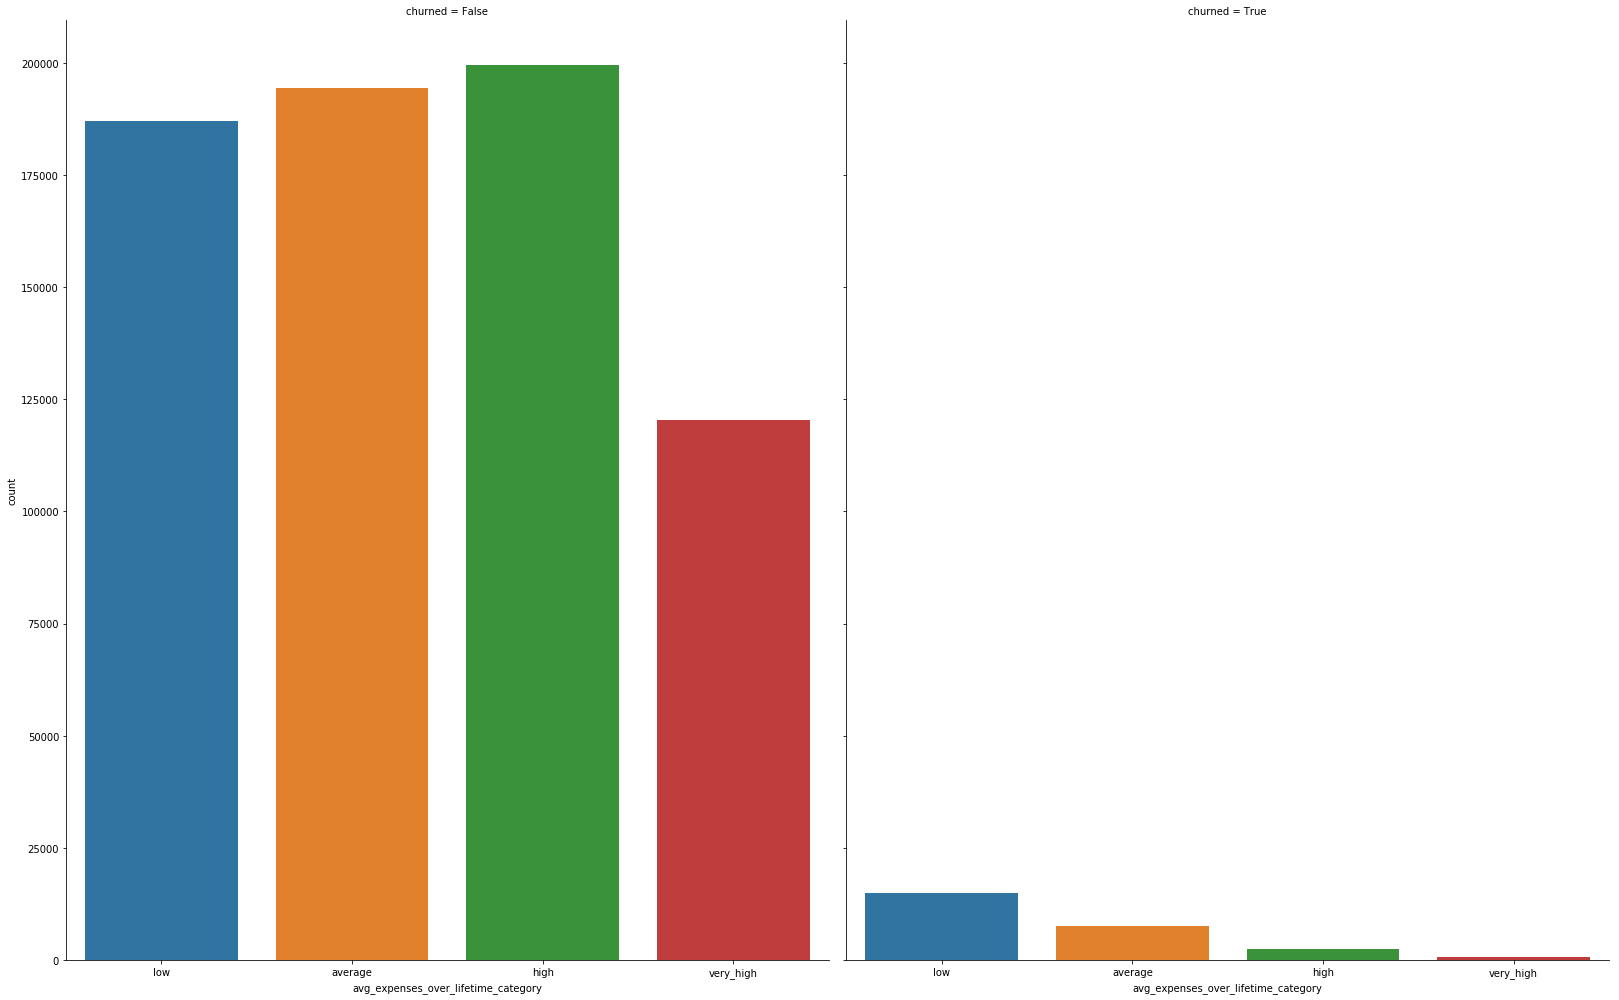

In [0]:
sns.factorplot(x="avg_expenses_over_lifetime_category",data=customer_churn_outlier_gone,col="churned",kind='count',aspect=.8,size=14)

### Conclusion:
The proportions of churns to non churns appears to be higher in the 'low budget' segment. This might seem intuitive as customers who spend very little across their entire time on the platform are not going to spend as often. 

### Action Plan: 
- One solution might be to market lower priced items to these customers or offer deals to entice the customers to continue spending over time.
- Budget conscious customers might also like to compare prices against other stores. Providing useful information that can help them understand how the product meets their needs can encourage them to buy from us.



### Hypothesis 3: Low purchase customers will have a higher risk of churning
- We define customers with fewer purchase in terms of how many times the customer purchases items with value > $1 
    - To get this, we first bin "num_of_purchases_total" into low(1) avg(2) high(3) very high(4)
    - We then see which range the customer falls under. The lower the bin, the higher the risk of churning 

C:\Users\ranon\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\ranon\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


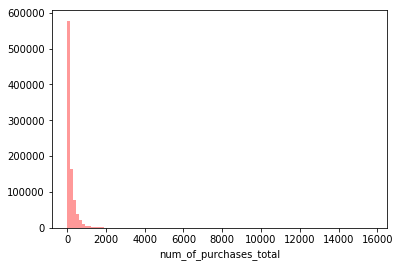

In [0]:
sns.distplot(customer_churn['num_of_purchases_total'], kde = False, color ='red', bins = 100)

### ** NOTE:  The original distribution of purchases is highly skewed. Removing some outliers (extremely big purchasers) might help us better understand the distribution amongst the rest of the population 

In [0]:
customer_churn_outlier_gone = remove_outlier(customer_churn,'num_of_purchases_total')

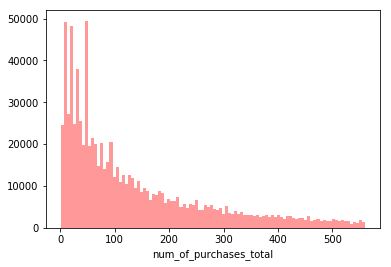

In [0]:
sns.distplot(customer_churn_outlier_gone['num_of_purchases_total'], kde = False, color ='red', bins = 100)

C:\Users\ranon\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\ranon\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


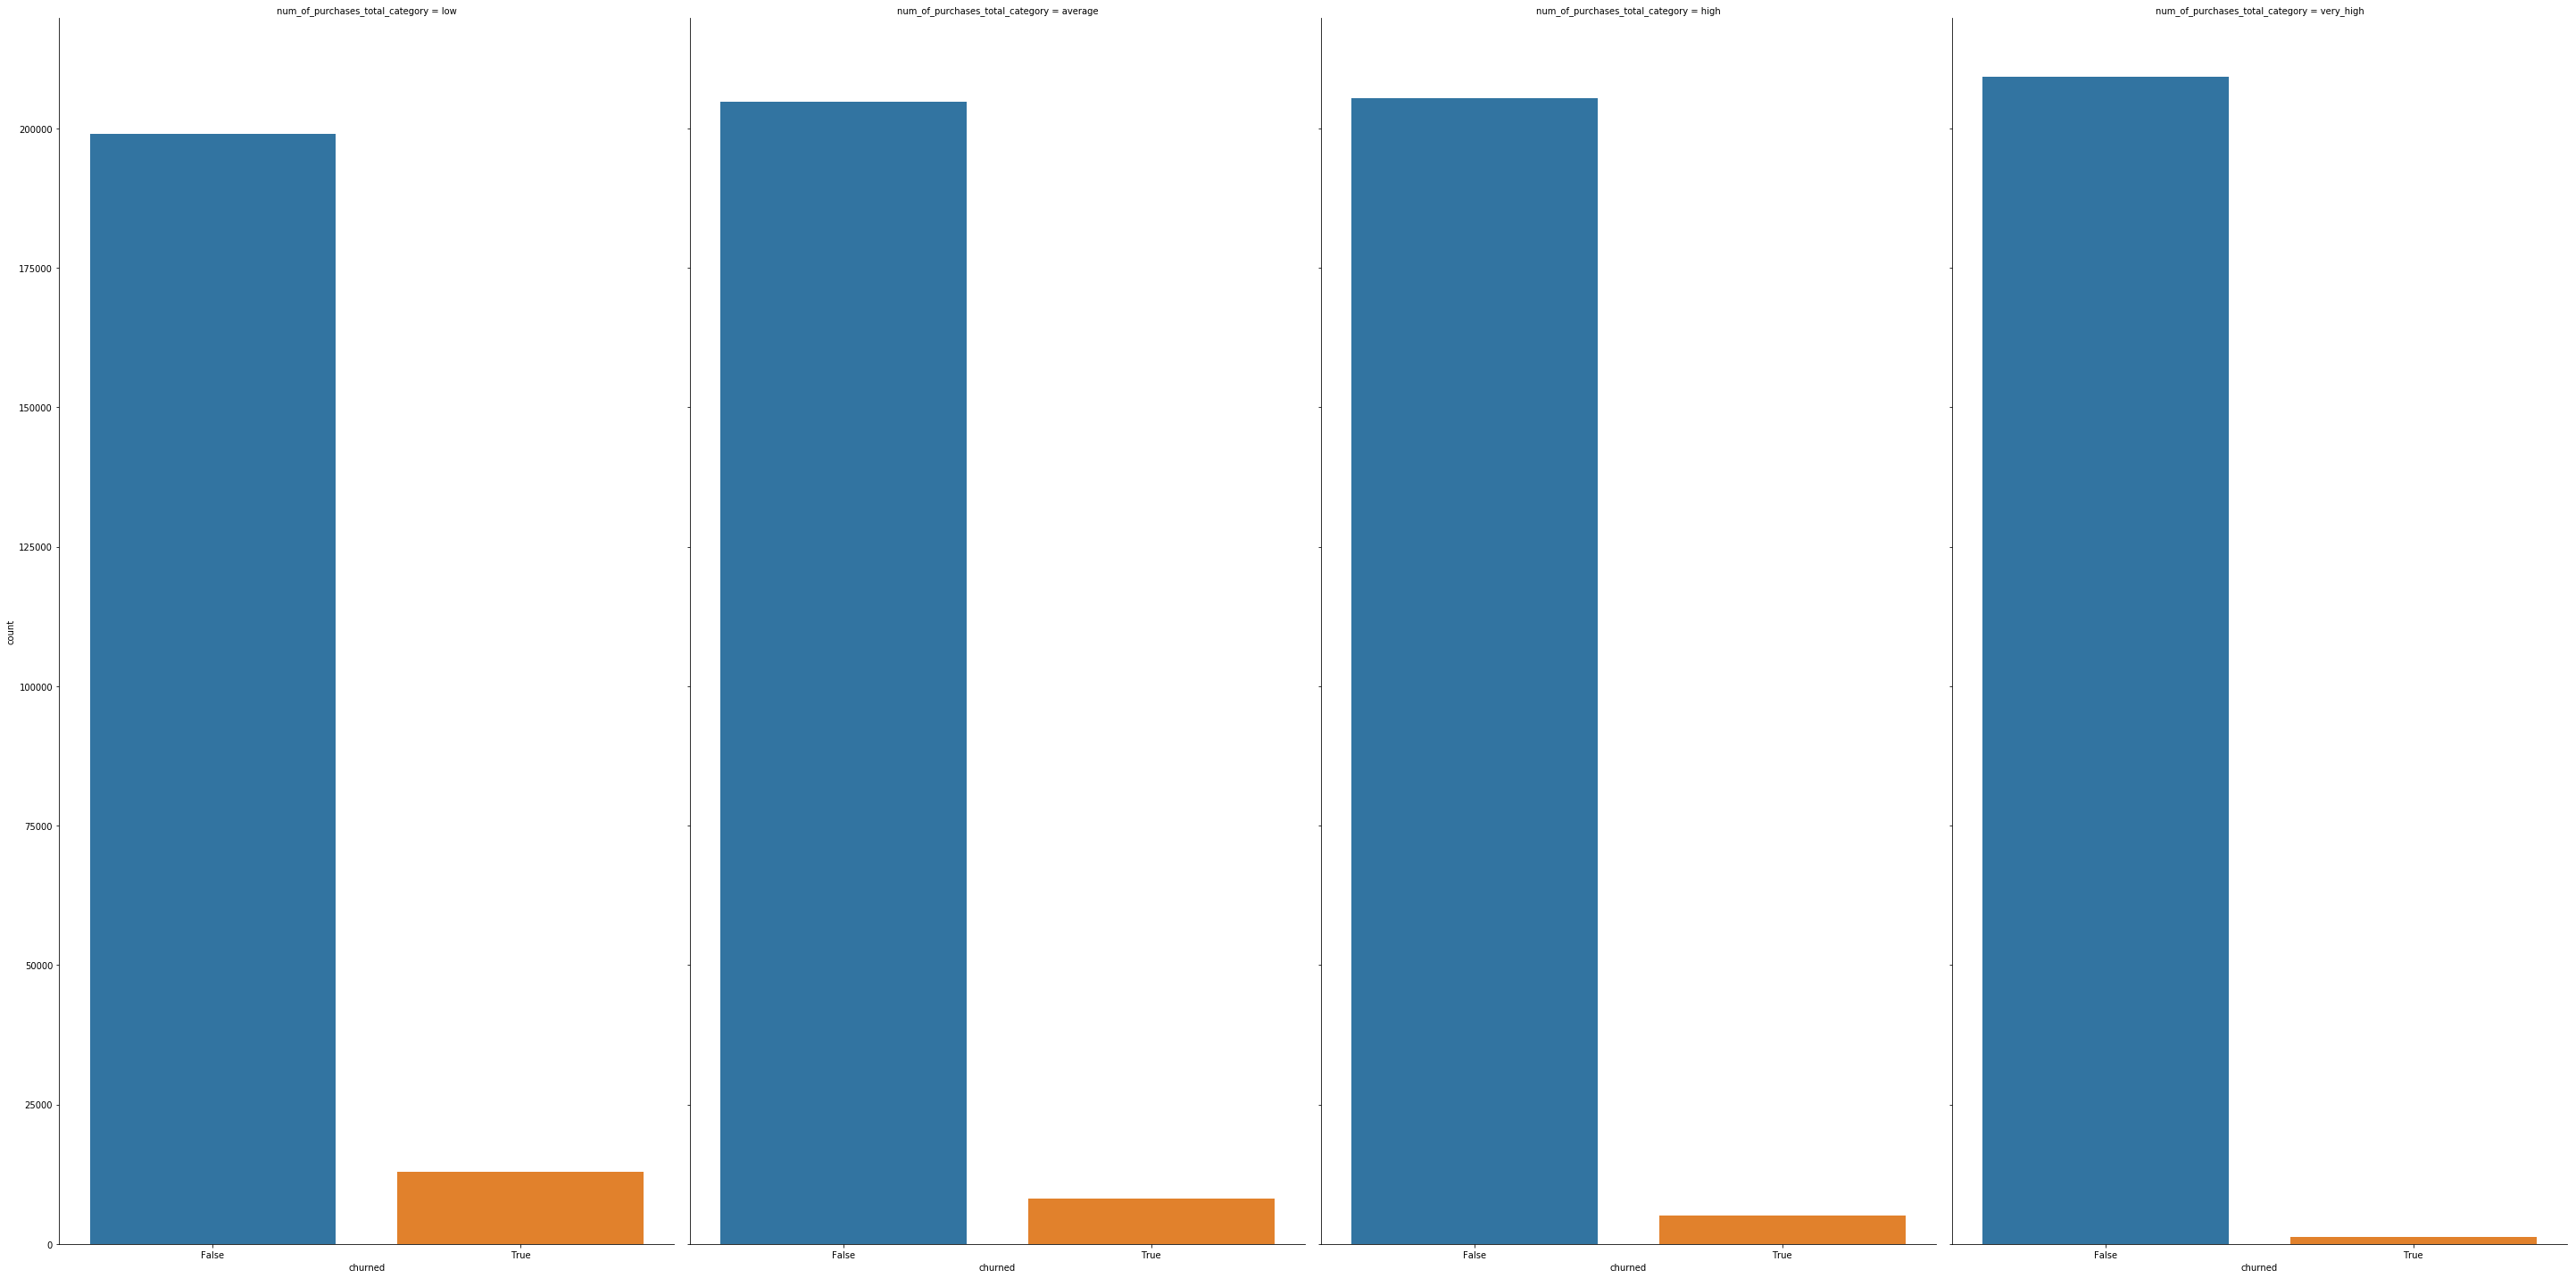

In [0]:
# quantiles=[0.1, 0.35,0.6,0.85, 1]
purchase_bin_labels = ['low', 'average', 'high', 'very_high']
customer_churn_outlier_gone['num_of_purchases_total_category'] = pd.qcut(customer_churn_outlier_gone['num_of_purchases_total'],
                              q=[0, 0.25,0.5,0.75, 1],
                              labels=purchase_bin_labels)
customer_churn_outlier_gone.head()

sns.factorplot(x="churned",data=customer_churn_outlier_gone,col="num_of_purchases_total_category",kind='count',aspect=0.5,size=20)

### Conclusion:
Similar to the low budget hypothesis, a larger Proportion of churns appear to come from the customers with the lowest number of items purchases(of value >= $1). As such, customers who buy less items have a higher chance of churning compared to those who purchase more. 

The image below confirms that the similar results between low budget customers and small purchase customers aren't due to any strong correlation between the two underlying features, num_of_purchases_total & avg_expenses_over_lifetime 

![image.png](attachment:image.png)



### Action Plan: 
- One solution might be to develop an upselling strategy that promotes relevant products to customers on top of any original purchase so that the customer will be enticed to purchase more without feeling pressured. 
- Drawing a customer’s attention to a limited-time deal can encourage them to take action and add on to their original purchase.

  


## Generate Churn Rate 

#### Calculation of Monthly Churn Rate: 

In [0]:
df_churn = customer_churn.groupby(['month_id','churned'])['payer_account_id'].nunique().unstack().reset_index()
df_churn['monthly_churn_rate'] = df_churn[True]/(df_churn[True]+df_churn[False])

df_churn.rename(columns={False:'NO_churn_agg_cnt_per_month',
                               True:'YES_churn_agg_cnt_per_month'},inplace=True)
customer_churn = pd.merge(customer_churn,df_churn,on=['month_id'])

#### Calculation of Customer's Churn Proportion i.e. #Months Churned / Total #Months in existence:

In [0]:
churn_df = customer_churn.groupby(['payer_account_id','month_id','churned'])['expenses_per_month'].nunique().unstack().fillna(0).reset_index()
churn_df_by_payer = churn_df.groupby(['payer_account_id'])[[False,True]].sum().reset_index()
churn_df_by_payer['cust_lifetime_churn_proportion'] = churn_df_by_payer[True]/(churn_df_by_payer[True]+churn_df_by_payer[False]) 

# Calculate Proportion of Churns in a customer's lifetime
customer_churn=pd.merge(customer_churn,churn_df_by_payer[['payer_account_id','cust_lifetime_churn_proportion']],on=['payer_account_id']) 


In [0]:
# # Calculate Yes and No Churn Indicator each month by customer# Calculate Proportion of Churns in a customer's lifetime
# customer_churn=pd.merge(customer_churn,churn_df,on=['payer_account_id','month_id'])  
# customer_churn.rename(columns={False:'NO_churn_indicator_for_month',
#                                True:'YES_churn_indicator_for_month'},inplace=True)

In [0]:
customer_churn.to_csv('output/customer_churn.csv')

In [0]:
product=pd.read_csv('product.csv')
product.describe().T
customer_churn = pd.merge(customer_churn,product[['product_sid','product_line_name','sub_product_name','service_group_name']],on=['product_sid'])

,count,unique,top,freq
product_sid,219014,219014,PHS000000000000049308,1
product_line_name,219014,116,Product Line 68,218056
product_name,219014,20465,Product 19696,53387
sub_product_name,219014,68,Sub Product 55,180451
service_group_name,219014,33,Service Group 6,204315
product_company_name,219014,6478,Product Company 4530,77010


# Model Building 

In [0]:
customer_churn= pd.read_csv('output/customer_churn.csv')

In [0]:
from sklearn.model_selection import cross_validate
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,roc_auc_score

### Preparing Data for Model Generation
- Customer Level for Churn Prediction - Binary Classification
    - Columns to use: 
    - X =    [
 'payer_account_status_code',
 'payer_account_role_name',
 'payer_account_creation_date',
 'payer_account_last_update_date',
 'is_payer_account_bill_in_90_days',
 'is_payer_account_enterprise',
 'is_payer_account_domain_free_domain',
 'is_payer_account_on_enterprise_support',
 'is_payer_account_fraud',
 'is_payer_account_suspended',
 'is_payer_account_tax_exempt',
 'is_payer_account_reseller',
 'payer_account_first_billing_reporting_date',
 'payer_account_first_payment_reporting_date',
 'payer_account_first_usage_date',
 'num_of_purchases_total',
 'perc_of_months_with_purchase',
 'expenses_per_month',
 'avg_expenses_over_lifetime']
    - Y = 'churned'

In [0]:
# churn_cols = ['churned','payer_account_status_code', 'payer_account_role_name', 'payer_account_creation_date', 'payer_account_last_update_date', 'is_payer_account_bill_in_90_days', 'is_payer_account_enterprise', 'is_payer_account_domain_free_domain', 'is_payer_account_on_enterprise_support', 'is_payer_account_fraud', 'is_payer_account_suspended', 'is_payer_account_tax_exempt', 'is_payer_account_reseller', 'payer_account_first_billing_reporting_date', 'payer_account_first_payment_reporting_date', 'payer_account_first_usage_date', 'expenses_per_month', 'avg_expenses_over_lifetime']
churn_cols = ['churned','payer_account_status_code', 'payer_account_role_name',
              'is_payer_account_bill_in_90_days', 'is_payer_account_enterprise',
              'is_payer_account_domain_free_domain', 'is_payer_account_on_enterprise_support',
              'is_payer_account_fraud', 'is_payer_account_suspended', 
              'is_payer_account_tax_exempt', 'is_payer_account_reseller','expenses_per_month',
              'avg_expenses_over_lifetime']
churn_model = customer_churn[churn_cols]

### Drop Missing Values: 
-  Total of 1816 missing values 

In [0]:
churn_model.isna().sum()

churned                                      0
payer_account_status_code                 1816
payer_account_role_name                   1816
is_payer_account_bill_in_90_days          1816
is_payer_account_enterprise               1816
is_payer_account_domain_free_domain       1816
is_payer_account_on_enterprise_support    1816
is_payer_account_fraud                    1816
is_payer_account_suspended                1816
is_payer_account_tax_exempt               1816
is_payer_account_reseller                 1816
expenses_per_month                           0
avg_expenses_over_lifetime                   0
dtype: int64

In [0]:
churn_model.dropna(inplace=True)

C:\Users\ranon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Handle Categorical Variables

In [0]:
churn_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 965054 entries, 0 to 966869
Data columns (total 13 columns):
churned                                   965054 non-null bool
payer_account_status_code                 965054 non-null object
payer_account_role_name                   965054 non-null object
is_payer_account_bill_in_90_days          965054 non-null object
is_payer_account_enterprise               965054 non-null object
is_payer_account_domain_free_domain       965054 non-null object
is_payer_account_on_enterprise_support    965054 non-null object
is_payer_account_fraud                    965054 non-null object
is_payer_account_suspended                965054 non-null object
is_payer_account_tax_exempt               965054 non-null object
is_payer_account_reseller                 965054 non-null object
expenses_per_month                        965054 non-null float64
avg_expenses_over_lifetime                965054 non-null float64
dtypes: bool(1), float64(2), object(10)
memo

In [0]:
churn_model['is_payer_account_bill_in_90_days'] = churn_model['is_payer_account_bill_in_90_days'].map({'Y': 1, 'N': 0})
churn_model['is_payer_account_on_enterprise_support'] = churn_model['is_payer_account_on_enterprise_support'].map({'Y': 1, 'N': 0})
churn_model['is_payer_account_suspended'] = churn_model['is_payer_account_suspended'].map({'Y': 1, 'N': 0})
churn_model['is_payer_account_domain_free_domain'] = churn_model['is_payer_account_domain_free_domain'].map({'Y': 1, 'N': 0})
churn_model['is_payer_account_reseller'] = churn_model['is_payer_account_reseller'].map({'Y': 1, 'N': 0})
churn_model['payer_account_status_code'] = churn_model['payer_account_status_code'].map({'Active': 1, 'Suspended': 0})
churn_model['payer_account_role_name'] = churn_model['payer_account_role_name'].map({'Regular': 1, 'Payer': 0,'Linked':-1})
churn_model['is_payer_account_enterprise'] = churn_model['is_payer_account_enterprise'].map({'Y': 1, 'N':0})
churn_model['is_payer_account_fraud'] = churn_model['is_payer_account_fraud'].map({'Y': 1, 'N':0})
churn_model['is_payer_account_tax_exempt'] = churn_model['is_payer_account_tax_exempt'].map({'Y': 1, 'N':0})


churn_model['churned']=churn_model['churned'].map({True:1,False:0})

C:\Users\ranon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\ranon\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\ranon\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

### Scale Variables 

In [0]:
churn_model_scaled = churn_model.copy()

In [0]:
columns = set(churn_model)
columns.remove('churned') 
for column in columns:
    churn_model_scaled[column] = RobustScaler().fit_transform(churn_model_scaled[column].values.reshape(-1, 1))
        
churn_model_scaled.head()

,churned,payer_account_status_code,payer_account_role_name,is_payer_account_bill_in_90_days,is_payer_account_enterprise,is_payer_account_domain_free_domain,is_payer_account_on_enterprise_support,is_payer_account_fraud,is_payer_account_suspended,is_payer_account_tax_exempt,is_payer_account_reseller,expenses_per_month,avg_expenses_over_lifetime
0,0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.118811,0.070792
1,0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.103959,0.070792
2,0,-1.0,0.0,-1.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,-0.104667,-0.117260
3,1,-1.0,0.0,-1.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,-0.132955,-0.117260
4,0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.321668,1.616229


### Split Data set into Test and Train

In [0]:
churn_X.columns

Index(['payer_account_status_code', 'payer_account_role_name',
       'is_payer_account_bill_in_90_days', 'is_payer_account_enterprise',
       'is_payer_account_domain_free_domain',
       'is_payer_account_on_enterprise_support', 'is_payer_account_fraud',
       'is_payer_account_suspended', 'is_payer_account_tax_exempt',
       'is_payer_account_reseller', 'expenses_per_month',
       'avg_expenses_over_lifetime'],
      dtype='object')

In [0]:
#splitting the train and test sets

churn_X = churn_model.drop(columns=['churned'])
# churn_X = churn_model.drop(columns=['churned','expenses_per_month','avg_expenses_over_lifetime'])

churn_y = churn_model['churned']
X_train, X_test, y_train,y_test= train_test_split(churn_X,churn_y,test_size=0.2)

### Train Decision Tree Model

In [0]:
clftree = tree.DecisionTreeClassifier(max_depth=3)
clftree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

C:\Users\ranon\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


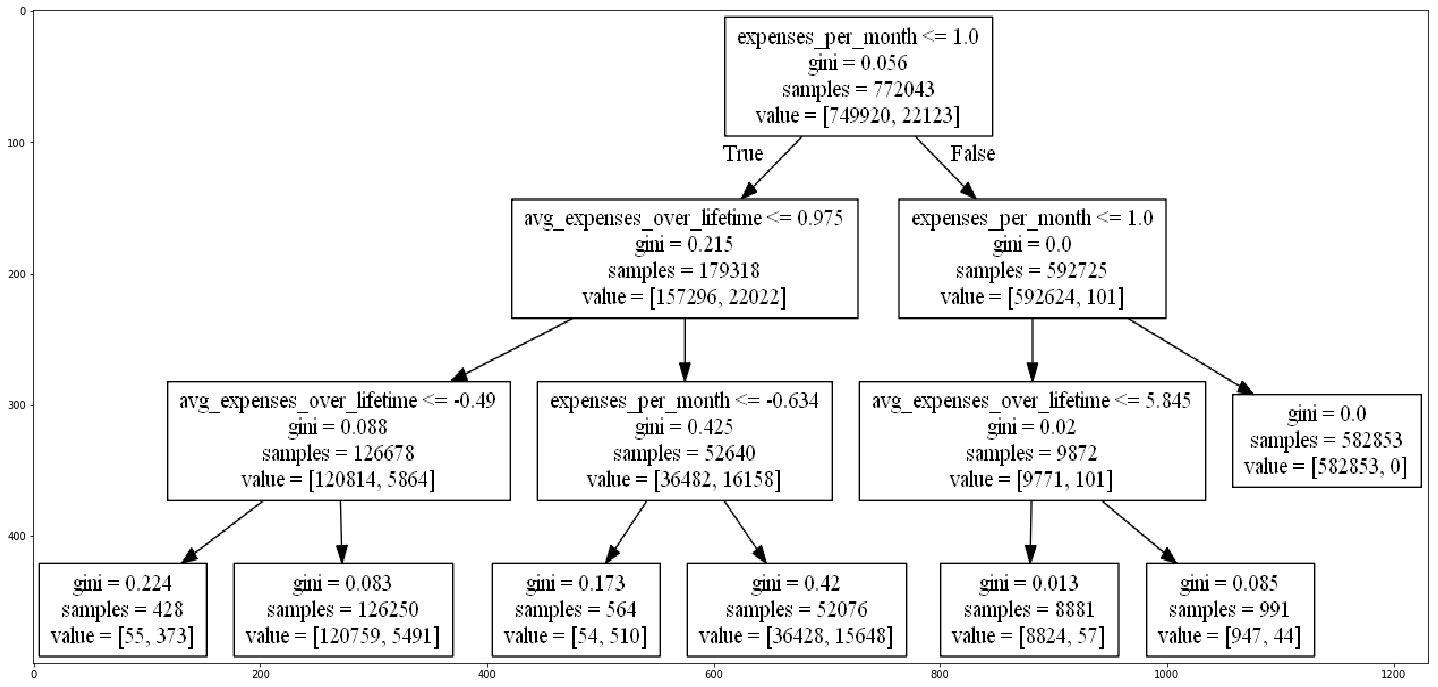

In [0]:
from scipy import misc
import pydotplus
import graphviz
import os

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"



def show_tree(decisionTree, file_path):
    tree.export_graphviz(decisionTree, out_file='tree.dot',feature_names=X_train.columns)
    graph = pydotplus.graphviz.graph_from_dot_file('tree.dot')
    graph.write_png('tree.png')
    i = misc.imread(file_path)
    
    fig, ax = plt.subplots(figsize=(25, 12))    
    ax.imshow(i, aspect='auto')

# To use it
show_tree(clftree, 'tree.png')

## Conclusion:
The Decision Tree was set to a max depth of 3 for illustration purposes as it's easier to interpret the tree with less depths.

From the tree above, we can conclude that: 
1) Customers who are likely to churn (looking at leafs 2,5,7) have the following traits: 
    - are on a debt (Expenses per month <-1 dollar ) + average lifetime expense with business < 1 dollar 
    - make very small purchases: expenses per month < 1 dollar

However, the tree appears to be dominated by two factors, namely avg_expenses_over_lifetime and expenses per month. Perhaps other features 

## Action Plan: 
- One solution might be to market lower priced items to these customers or offer deals to entice the customers to continue spending over time.
- Budget conscious customers might also like to compare prices against other stores. Providing useful information that can help them understand how the product meets their needs can encourage them to buy from us.



## Plotting The Decision Tree again without Revenue Features (only Customer Features):
![image.png](attachment:image.png)

### Conclusion:
With only Customer Features, we can derive certain conclusions: 

1) Customers who are likely to churn (looking at leafs 4) have the following traits: 
    - do not have a free domain, is either a linked or payed customer (not regular) and has no bill in 90 days (leading to a gini of 0.021)


### Action Plan: 
- Knowing these customer traits can help the team to do a preliminary segmentation of customers into various target groups and dive deeper into the reasons behind them churning

## Generating Feature Importance from Gradient Boosted Tree - This provides us with a list of features that the model deemed as important in explaining why a user had churned.

In [0]:
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbc_predictions = gbc.predict(X_test)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    187498
           1       0.00      0.00      0.00      5513

   micro avg       0.97      0.97      0.97    193011
   macro avg       0.49      0.50      0.49    193011
weighted avg       0.94      0.97      0.96    193011

0.5
[0.10117059 0.02715174 0.25615498 0.         0.4819181  0.00472466
 0.00694024 0.11567428 0.         0.0062654 ]


C:\Users\ranon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ranon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ranon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


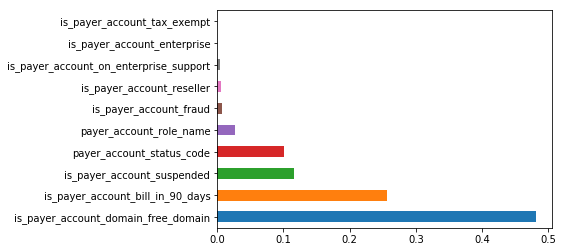

In [0]:

#GBC
print(classification_report(y_test,gbc_predictions ))  
print(roc_auc_score(y_test, gbc_predictions ))



print (gbc.feature_importances_)
gbc_feat_importances = pd.Series(gbc.feature_importances_, index=churn_X.columns)
gbc_feat_importances.nlargest(10).plot(kind='barh')


### Conclusion:

From the feature importance chart, we can conclude that whether a payer account is a free domain / if a payer has a bill 90 days and is the payer active/suspended are the top three important factors deciding whether a customer will churn or not.  

## Additional Exploration to be done in the future: 

- 1. Add Product Features
    - (Distinct Count of sub_product_name / service_group_name) purchased from per customer each month
    - Doing so can reveal if a customer likes to purchase across many product categories which may be a factor affecting the total sales of a customer each month
- 2. Add Territory Features 
    - Look at how different segments vary in terms of purchases and sales revenue

## Additional Modelling to be done in the future: 
- Incorporate time based features like 'payer_account_first_payment_reporting_date'
    - https://datascience.stackexchange.com/questions/2368/machine-learning-features-engineering-from-date-time-data
- Try different models 
- Incorporate SHAP values in order to quantify the effect a feature has whether a customer will churn


# Tableau Dashboard Analysis

![image.png](attachment:image.png)

# Insights from Dashboard: 



![image.png](attachment:image.png)

- The  Monthly churn rate decreases gradually over the years, more significantly during the 4th quarter of the year. 
- There appears to be a seasonal pattern in churn rate across the months, with some deviation (spikes) occurring on some months

![image.png](attachment:image.png)

- Churn Rate appears to be similar across different Territorial segments
- APAC segment 4 has the highest median and average churn rate per customer
- APAC segment 5 displays the highest spread in churn rate and customers with highest churn rate 

![image.png](attachment:image.png)

- Customers who churn tend to be those with lower expenditure (budget) and total purchases (less active)

![image.png](attachment:image.png)

- Baseline sales revenue (Sales in Dec the previous year) seems to have a slight negative correlation with churn rate. As baseline sales decreases, churn rate increases. 
- Baseline sales could thus be an indicator of whether there is  going to happen higher churn rate in the reporting month 

![image.png](attachment:image.png)

- There is a strong negative correlation between expenses and monthly churn rate. Lower expenses likely means that customers are spending less in the month